In [53]:
import pandas as pd
import numpy as np
import sklearn as skl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, train_test_split
from IPython.display import clear_output
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from sklearn import tree
from sklearn.model_selection import GridSearchCV

1.- Preprocesamiento, Análisis Exploratorio de Datos e Ingeniería de Atributos

In [54]:
# Ingestamos datos de entrenamiento y prueba. 
# Sabemos que ambas tienen la misma cantidad de caracteristicas, 
# exceptuando la columna target ('Stay (in days)') que no está presente en el conjunto de prueba.
Train_set = pd.read_csv('hospitalizaciones_train.csv')
Test_set = pd.read_csv('hospitalizaciones_test.csv')

In [55]:
Train_set.info()
Train_set.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410000 entries, 0 to 409999
Data columns (total 15 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Available Extra Rooms in Hospital  410000 non-null  int64  
 1   Department                         410000 non-null  object 
 2   Ward_Facility_Code                 410000 non-null  object 
 3   doctor_name                        410000 non-null  object 
 4   staff_available                    410000 non-null  int64  
 5   patientid                          410000 non-null  int64  
 6   Age                                410000 non-null  object 
 7   gender                             410000 non-null  object 
 8   Type of Admission                  410000 non-null  object 
 9   Severity of Illness                410000 non-null  object 
 10  health_conditions                  410000 non-null  object 
 11  Visitors with Patient              4100

Available Extra Rooms in Hospital        18
Department                                5
Ward_Facility_Code                        6
doctor_name                               9
staff_available                          11
patientid                            122394
Age                                      10
gender                                    3
Type of Admission                         3
Severity of Illness                       3
health_conditions                         6
Visitors with Patient                    28
Insurance                                 2
Admission_Deposit                    409682
Stay (in days)                           49
dtype: int64

Con esto sabemos que no existen datos faltantes en ninguna columna y el tipo de dato que posee cada una. También obtenemos el número de datos repetidos que tiene cada columna, lo que nos facilitará la asignación de etiquetas a las variables categóricas.
A continuación observamos en detalle el dataframe a trabajar. 

In [56]:
Train_set.head(4)

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,Stay (in days)
0,4,gynecology,D,Dr Sophia,0,33070,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,8
1,4,gynecology,B,Dr Sophia,2,34808,31-40,Female,Trauma,Minor,Heart disease,2,No,3554.835677,9
2,2,gynecology,B,Dr Sophia,8,44577,21-30,Female,Trauma,Extreme,Diabetes,2,Yes,5624.733654,7
3,4,gynecology,D,Dr Olivia,7,3695,31-40,Female,Urgent,Moderate,None,4,No,4814.149231,8


Las columnas 'Available Extra Rooms in Hospital', 'staff_available', 'patienid', 'Visitors with Patient' y 'Stay (in days)' poseen datos numéricos. Las columnas 'Department', 'doctor_name', 'ward_facility_code'. 'gender', 'Type of Admission', health_conditions e Insurance poseen datos tipo string categóricos, mientras que 'Age' y 'Severity of Illnes' contienen datos string ordinales.

In [57]:
#Siguiendo la consigna, convertimos la columna 'Stay' del dataset de entrenamiento en una de tipo de binario 
#para usarla como variable objetivo.
Train_set['Long_stay'] = Train_set['Stay (in days)'] > 8
Train_set['stay_target'] = np.where(Train_set['Long_stay'], 1, 0)
Train_set = Train_set.drop(['Long_stay', 'Stay (in days)'], axis=1)

In [58]:
# Asignamos etiquetas (tipo label enconder) a las columnas con datos ordinales en ambos datasets
Dicc = {'0-10':0, '11-20':1, '21-30':2, '31-40':3, '41-50':4, '51-60':5, '61-70':6, '71-80':7, '81-90':8, '91-100':9}
Train_set['Age_range'] = Train_set['Age'].map(Dicc)
Dicc2 ={'Minor':0, 'Moderate':1, 'Extreme':2}
Train_set['Illness_severity'] = Train_set['Severity of Illness'].map(Dicc2)
Test_set['Age_range']= Test_set['Age'].map(Dicc)
Test_set['Illness_severity']= Test_set['Severity of Illness'].map(Dicc2)

In [59]:
#Asignamos etiquetas dummies (tipo one hot encoder) a las columnas con datos categóricos en ambos datasets
Train_encoded = pd.get_dummies(Train_set, columns=['Department', 'Ward_Facility_Code' ,'doctor_name','gender' , 'Type of Admission','health_conditions', 'Insurance'])
Test_encoded = pd.get_dummies(Test_set, columns=['Department', 'Ward_Facility_Code' ,'doctor_name','gender' , 'Type of Admission','health_conditions', 'Insurance'])

In [60]:
#Eliminamos columnas redundantes y Redefinimos Datasets
DF_Train_encoded = Train_encoded.drop(['Age','Severity of Illness'], axis=1)
DF_Test_encoded = Test_encoded.drop(['Age','Severity of Illness'], axis=1)

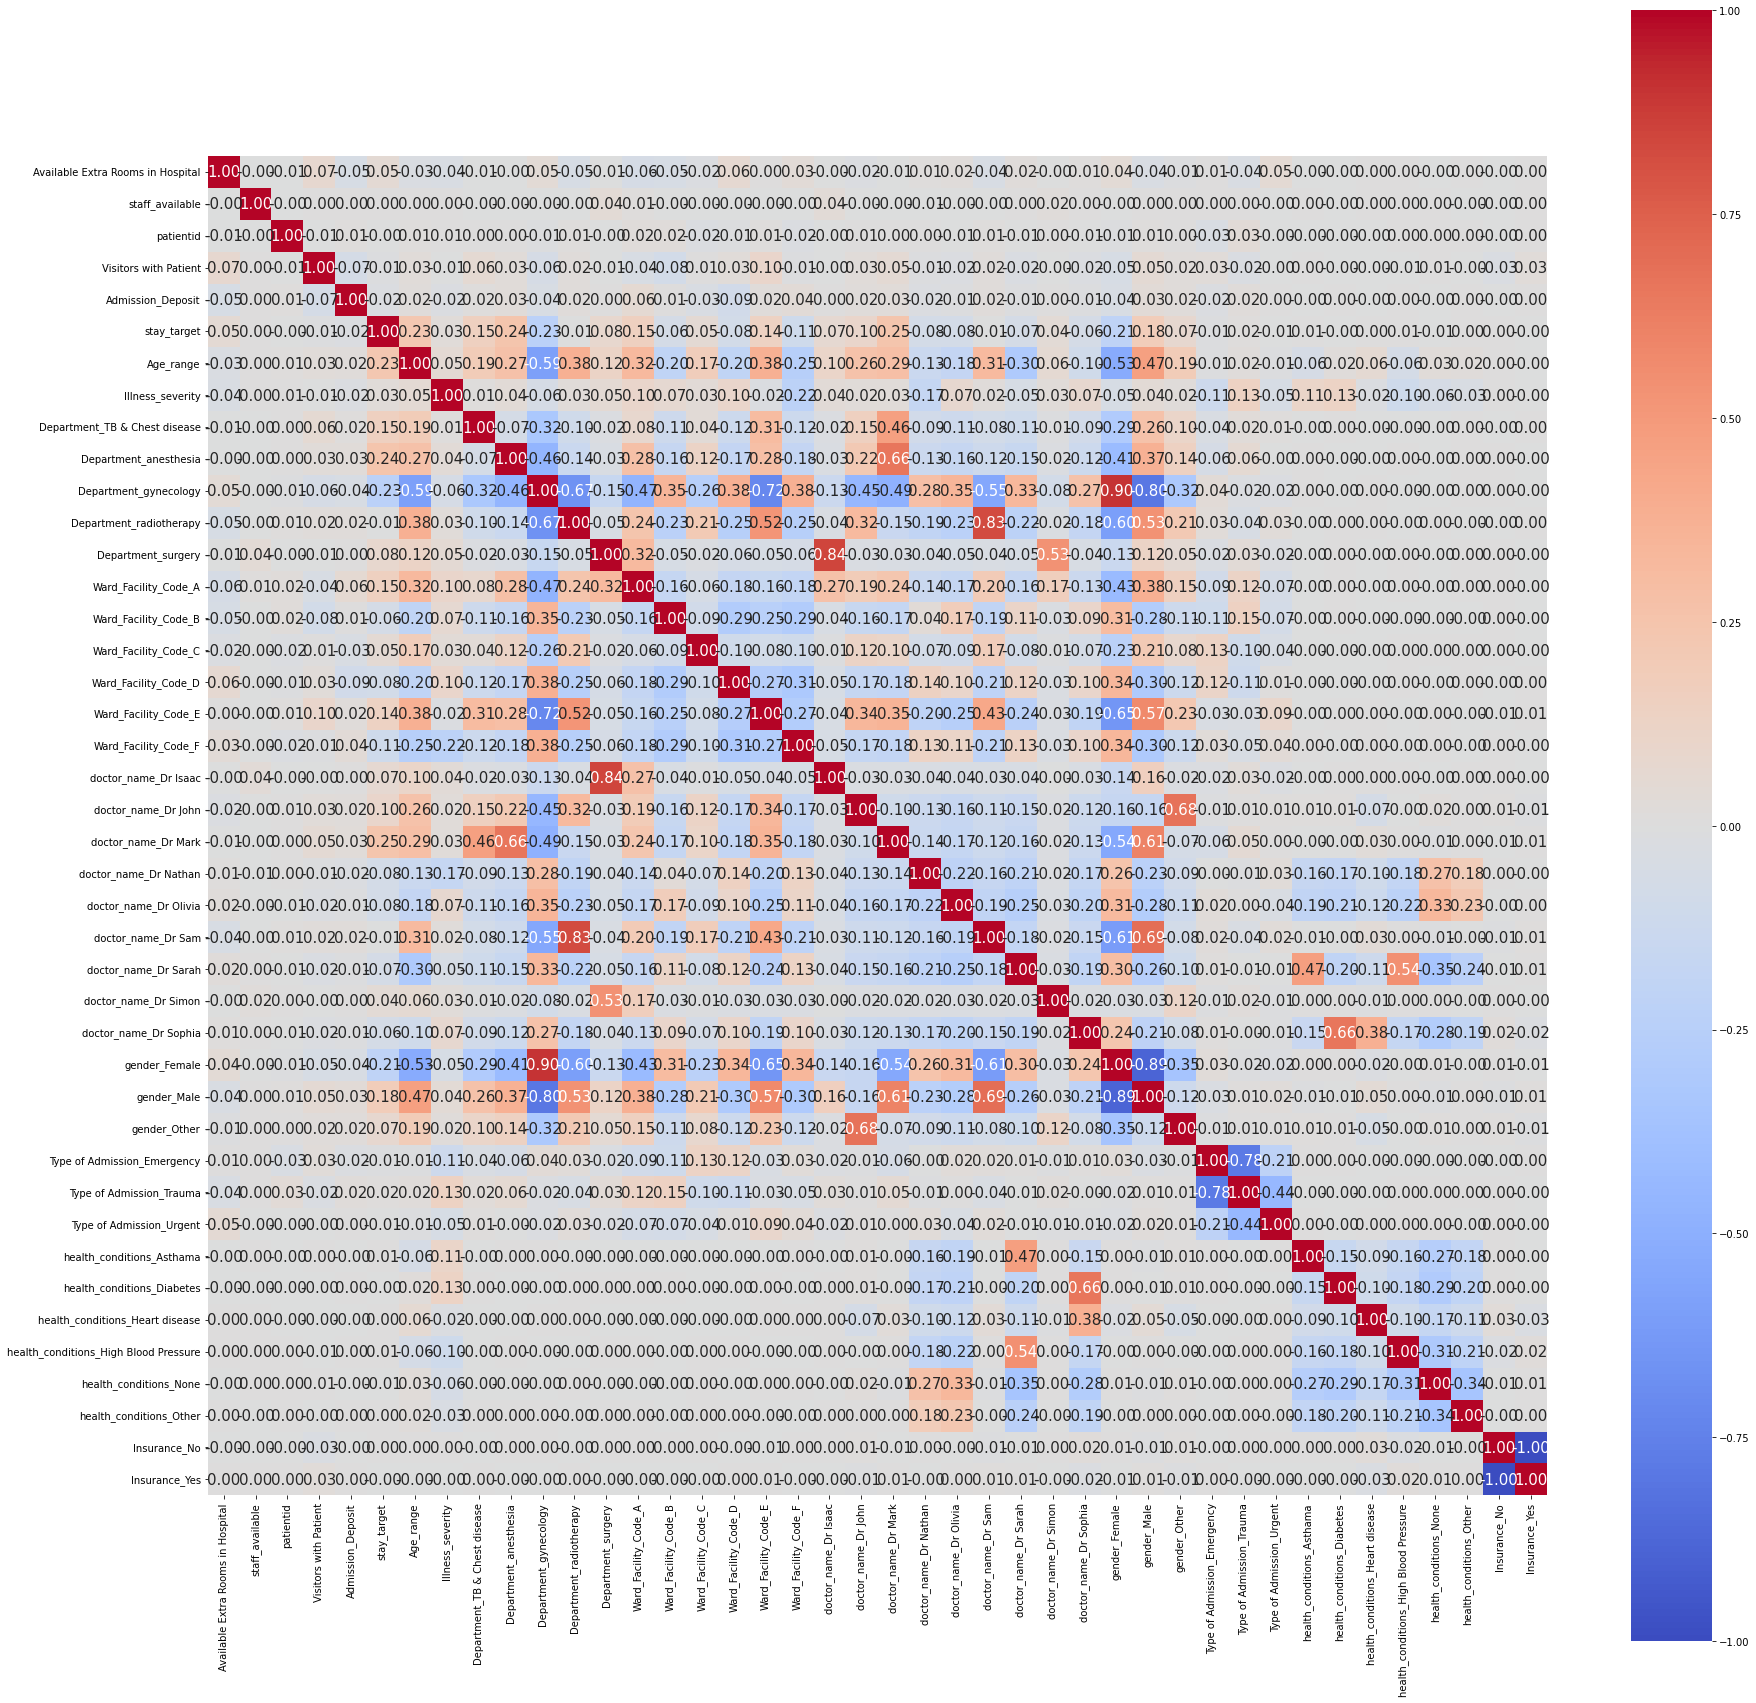

In [61]:
corr = DF_Train_encoded.corr(method='pearson') 
plt.figure(figsize=(30,30))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= DF_Train_encoded.columns, 
           yticklabels= DF_Train_encoded.columns,
           cmap= 'coolwarm')

plt.show()

Notamos que, en general existe una baja correlación entre los atributos del modelo. Sin embargo, la caracteristica 'Department of gynecology' tiene una alta correlacion tanto positiva con la caracteristica 'Female_gender' (0.9) como negativa con 'Male_gender' (0.8), esto sugiere información redundante contenida en 'Departement_ginecology' por lo que se procede a eliminar este atributo, de esta forma se espera reducir el sesgo del modelo.

In [62]:
#Obtenemos listado de correlaciones de todas las dimensiones con la variable objetivo
DF_Train_encoded.corr()['stay_target'].sort_values(ascending=False)

stay_target                              1.000000
doctor_name_Dr Mark                      0.246904
Department_anesthesia                    0.242282
Age_range                                0.229657
gender_Male                              0.184325
Department_TB & Chest disease            0.154842
Ward_Facility_Code_A                     0.150734
Ward_Facility_Code_E                     0.138988
doctor_name_Dr John                      0.099091
Department_surgery                       0.078740
gender_Other                             0.072283
doctor_name_Dr Isaac                     0.066519
Available Extra Rooms in Hospital        0.053894
Ward_Facility_Code_C                     0.050095
doctor_name_Dr Simon                     0.041826
Illness_severity                         0.028064
Type of Admission_Trauma                 0.015249
health_conditions_High Blood Pressure    0.006233
health_conditions_Asthama                0.005211
staff_available                          0.002883


Nuevamente se observa una correlación débil entre la variable objetivo y las demas caracteristicas del modelo. Esto sugiere una alta varianza en las caracteristicas para la clasificación.
Para aclarar un poco mas la situación estudiamos los componentes principales del modelo

In [63]:
#Escalamos el modelo
scaler = MinMaxScaler()
DF_rescaled = scaler.fit_transform(DF_Train_encoded)

Text(0, 0.5, 'cumulative explained variance')

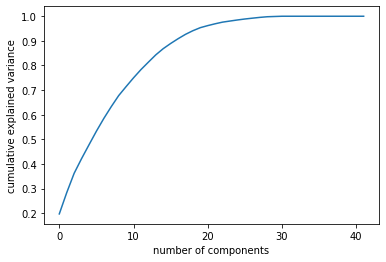

In [64]:
#Construimos un gráfico de la varianza explicada vs el número de componentes
pca = PCA().fit(DF_rescaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Este gráfico muestra claramente que para obtener una alta varianza explicada no es posible eliminar muchas dimensiones, aunque estas no tengan una gran correlación con la columna objetivo. Mas especificamente, para obtener un indice del 90% de la varianza explicada, se necesita al menos 15 componentes en el modelo.

In [65]:
#Se procede a determinar las características que tienen una muy débil correlación con la columna objetivo
low_corr = (DF_Train_encoded.corr()['stay_target'] < 0.05) & (DF_Train_encoded.corr()['stay_target'] > -0.05)
DF_Train_encoded.columns[low_corr]

Index(['staff_available', 'patientid', 'Visitors with Patient',
       'Admission_Deposit', 'Illness_severity', 'Department_radiotherapy',
       'doctor_name_Dr Sam', 'doctor_name_Dr Simon',
       'Type of Admission_Emergency', 'Type of Admission_Trauma',
       'Type of Admission_Urgent', 'health_conditions_Asthama',
       'health_conditions_Diabetes', 'health_conditions_Heart disease',
       'health_conditions_High Blood Pressure', 'health_conditions_None',
       'health_conditions_Other', 'Insurance_No', 'Insurance_Yes'],
      dtype='object')

Se establece este criterio para la eliminación de dimensiones, esto es, que posean un correlación < |0.05|. Además de la columna 'Department_gynecology', como fue señalado anteriormente. 

In [66]:
DF_Train = DF_Train_encoded.drop(['stay_target', 'staff_available', 'patientid', 'Visitors with Patient',
       'Admission_Deposit', 'Illness_severity', 'Department_radiotherapy',
       'doctor_name_Dr Sam', 'doctor_name_Dr Simon',
       'Type of Admission_Emergency', 'Type of Admission_Trauma',
       'Type of Admission_Urgent', 'health_conditions_Asthama',
       'health_conditions_Diabetes', 'health_conditions_Heart disease',
       'health_conditions_High Blood Pressure', 'health_conditions_None',
       'health_conditions_Other', 'Insurance_No', 'Insurance_Yes'], axis=1)

In [93]:
X = DF_Train
y = DF_Train_encoded['stay_target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [90]:
X_test2 = DF_Test_encoded.drop(['staff_available', 'patientid', 'Visitors with Patient',
       'Admission_Deposit', 'Illness_severity', 'Department_radiotherapy',
       'doctor_name_Dr Sam', 'doctor_name_Dr Simon',
       'Type of Admission_Emergency', 'Type of Admission_Trauma',
       'Type of Admission_Urgent', 'health_conditions_Asthama',
       'health_conditions_Diabetes', 'health_conditions_Heart disease',
       'health_conditions_High Blood Pressure', 'health_conditions_None',
       'health_conditions_Other', 'Insurance_No', 'Insurance_Yes'], axis=1)

2.- Implementación de modelos de MAchine Learning
2.1.- Arbol de decisión

In [69]:
# Estudiamos el comportamiento del arbol de decision estableciendo diferentes instancias 
# del modelo para diferentes profundidades junto a una medida de su rendimiento

tree_train_scores_mean = []
tree_train_scores_std = []
tree_test_scores_mean = []
tree_test_scores_std = []

profundidades = np.arange(1,30,1)
i = 0
i_max = len(profundidades)
for profundidad in profundidades:
    i = i + 1
    arbol = DecisionTreeClassifier(max_depth=profundidad)
    tree_scores = cross_validate(arbol, X, y, cv=5, return_train_score=True, n_jobs = -1)
    
    tree_train_scores_mean.append(tree_scores['train_score'].mean())
    tree_train_scores_std.append(tree_scores['train_score'].std())
    
    tree_test_scores_mean.append(tree_scores['test_score'].mean())
    tree_test_scores_std.append(tree_scores['test_score'].std())
    
    clear_output(wait=True)
    print('Completado: ' + str(round(i / i_max * 100, 2)) + '%')

tree_train_scores_mean = np.array(tree_train_scores_mean)
tree_train_scores_std = np.array(tree_train_scores_std)
tree_test_scores_mean = np.array(tree_test_scores_mean)
tree_test_scores_std = np.array(tree_test_scores_std)

Completado: 100.0%


In [70]:
tree_scores

{'fit_time': array([3.21102524, 3.25199509, 3.24300361, 3.27498364, 1.06234717]),
 'score_time': array([0.04896808, 0.05296898, 0.05696344, 0.06096363, 0.02998328]),
 'test_score': array([0.69491463, 0.69609756, 0.69676829, 0.69789024, 0.69873171]),
 'train_score': array([0.69990549, 0.69993598, 0.69965854, 0.69933232, 0.6992622 ])}

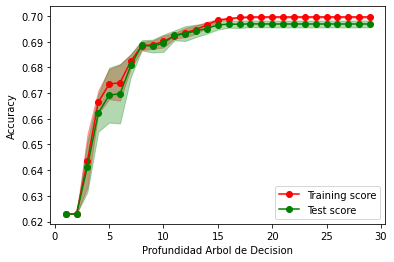

In [71]:
plt.fill_between(profundidades, tree_train_scores_mean - tree_train_scores_std,
                 tree_train_scores_mean + tree_train_scores_std, alpha=0.3,
                 color="r")
plt.fill_between(profundidades, tree_test_scores_mean - tree_test_scores_std,
               tree_test_scores_mean + tree_test_scores_std, alpha=0.3, color="g")

plt.plot(profundidades, tree_train_scores_mean, 'o-', color="r",
            label="Training score")
plt.plot(profundidades, tree_test_scores_mean, 'o-', color="g",
            label="Test score")

plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Profundidad Arbol de Decision')
plt.show()

El gráfico muestra el comportamiento de la profundidad del arbol vs el accuracy para datos de test y entrenamiento.

In [72]:
#usamos el método GridSearch con validación cruzada para obtener el mejor parámetro de profundidad
arbol = DecisionTreeClassifier()
parameters = {'max_depth':[10,12,14,16,18]}
model = GridSearchCV(arbol,cv=5,param_grid=parameters)
model.fit(X,y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [10, 12, 14, 16, 18]})

In [73]:
model.best_params_

{'max_depth': 18}

In [91]:
arbol = DecisionTreeClassifier(max_depth=18)
arbol.fit(X_train,y_train)


DecisionTreeClassifier(max_depth=18)

In [94]:
y_pred = arbol.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.66      0.39      0.49     46130
           1       0.71      0.88      0.78     76870

    accuracy                           0.70    123000
   macro avg       0.69      0.64      0.64    123000
weighted avg       0.69      0.70      0.67    123000



A continuación realizamos la predicción sobre el dataset de prueba

In [76]:
prediction = arbol.predict(X_test)

In [77]:
DF_pred = pd.DataFrame(prediction, columns=['pred'])

In [97]:
DF_pred.to_csv('huepilche.csv', index=False)

2.2 Máquina de Soporte Vectorial

In [98]:
#Escalamos la columna de edades entre 0 y 1
DF_Train_scaled = minmax_scale(X['Age_range'],feature_range=(0,1))
X['age_norm']=DF_Train_scaled
X_norm = X.drop(['Age_range'],axis=1)
DF_Test_scaled = minmax_scale(X_test2['Age_range'],feature_range=(0,1))
X_test2['age_norm']=DF_Test_scaled
X_test_norm = X_test2.drop(['Age_range'],axis=1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_norm, y, test_size=0.30)

In [ ]:
#Usamos la función GrSearch con validación cruzada para obtener los parámetros mas adecuados de nuestro modelo. 
#Usamos un Kernel Gaussiano.
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]}
svm_model = SVC(kernel='rbf', random_state=42)
grid = GridSearchCV(svm_model, param_grid, cv=4, refit=True, verbose=2)
grid.fit(X_norm,y)

Luego de ejecutar esta función (realizada en Google Colab por un tema de recursos), se obtienen los parámetros
'C' = 100 y 'gamma'= 1 . A continuación instanciamos la SVC y realizamos el entrenamiento correspondiente (tambien realizados en Google Colab).

In [ ]:
clf = SVC(kernel='rbf', gamma = 1, C = 100)
clf.fit(X_train2, y_train2)

Finalmente se realizan las predicciones y el reporte de clasificación

In [ ]:
predictions = clf.predict(X_test2)
print (classification_report(y_test2,predictions))

https://colab.research.google.com/drive/1sqm6aC5v3uCTUCwEBy_XPR0GS2giJLCc#scrollTo=f_CWDE1hJ-3i&line=1&uniqifier=1